In [ ]:
# lets view kmeans as a latent variable model where z is one-hot descrete latent variable
from torch.distributions.dirichlet import Dirichlet
from torch.nn.functional import one_hot
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class LVKmeans(nn.Module):
    def __init__(self, n_centroids, output_dim, latent_size=400):
        super(LVKmeans, self).__init__()
        self.n_centroids = n_centroids
        self.output_dim = output_dim
        self.latent_size = latent_size
        # decoder is a linear layer
        #output_dim = n_centroids
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, output_dim, bias=False),
        )
        # init z to one-hot descrete latent variable
        self.z = nn.Parameter(
            Dirichlet(torch.ones(n_centroids)).sample((latent_size,)).T
            , requires_grad=True
        )
        self.projector = nn.Sequential(
            nn.Linear(n_centroids, n_centroids *10),
            nn.ReLU(),
            nn.Linear(n_centroids *10, n_centroids *100),
            nn.ReLU(),
            nn.Linear(n_centroids *100, n_centroids *10),
            nn.ReLU(),
            nn.Linear(n_centroids *10, n_centroids),
        )
        self.z_l = None
        self.z_l_fuzzy = None
            
        
    def col_one_hot(self, z):
        # one hot encoding
        #z = torch.argmax(z, dim=0)
        z = torch.argmin(z, dim=0)
        z = one_hot(z, num_classes=self.n_centroids).T
        if self.n_centroids == self.latent_size:
            # make z eye matrix
            z = torch.eye(self.n_centroids)

        return z.float()
    
    def get_z(self):
        return self.z
    
    # sample z from without one-hot encoding
    def sample_z(self, regularize=False):
        if regularize:
            z = self.z
        else:
            z = torch.bernoulli(self.z)
        y = self.decoder(z)
        return y, z

    def forward(self, z):
        z = self.col_one_hot(z)
        # make z dtype float
        y = self.decoder(z)
        self.z_l = y
        # make y fuzzy
        y = y + torch.randn(y.shape)* 1
        self.z_l_fuzzy = y
        y = self.projector(y.T).T
        return y
sq, qp = loadData(100)
sq = torch.from_numpy(sq).float()
sq = squares
# =============================================================================
n_centroids = 4
output_dim = 2
latent_size = 400
model = LVKmeans(n_centroids, output_dim, latent_size=latent_size)
#from ebmUtils import *

# criterion
from src.metrics import Linf_simple
from src.ebmUtils import loss_functional
criterion = Linf_simple
# optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
c2 = nn.MSELoss()
# epochs
epochs = 100
times = 1
p_times = epochs / times
# create times * figures
col = 4
row = int(times / col) + 1
#fig, axs = plt.subplots(row, col, figsize=(10, 10))
# y = torch.tensor(spiral_data, dtype=torch.float32)
y = sq
# input =torch.from_numpy(spiral_data).float()
input = sq
costs = []
best_model = None
best_cost = float('inf')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
costs = []
rem = []
reg = []
rem.append(torch.tensor(1))
p_c = []
p_p = []
p_e = []
reg_let_r = []
reg_cost_r = []
models = []
test = False
z_l =[]
z_l_fuzzy = []
c_l = []
c_l_fuzzy = []
std = []
mu =[]
for epoch in range(epochs):

    # forward
    outputs = model(model.z)

    # add random noise
    c_l.append(outputs)
    if epoch %1000 == 0:
        scale = 100
        std_ = rem[-1].item()/scale
        outputs = outputs + torch.randn_like(outputs)*std_
        std.append(std_)
        mu.append(outputs)
    # calculate cost
    c_l_fuzzy.append(outputs)
    # make outputs numpy
    cost = loss_functional(outputs, y, model)
    c1 = cost
    F, z = cost.min(1)
    rem.append(torch.sum(F))
    cost = torch.mean(F) 
    #cost = torch.sum(F) + reg_cost + reg_let
    if test == True and epoch > 100000:
        cost = c2_cost + reg_cost + reg_let + c3_cost
    reg.append(0)
    # append latents
    z_l.append(model.z_l)
    z_l_fuzzy.append(model.z_l_fuzzy)
    # backward
    optimizer.zero_grad()
    # make sure cost is torch tensor
    costs.append(cost.item())
    #rem.append(cost)
    cost.backward()
    optimizer.step()
    if cost < best_cost:
        best_cost = cost
        best_model = model
        best_outputs = outputs
        best_z = z
        best_lat = model.z_l
        best_epoch = epoch
    if cost < 6000:
        p_p.append(outputs)
        p_c.append(cost)
        p_e.append(epoch)
    # print
    if (epoch + 1) % p_times == 0:
        # print
        print('Epoch [{}/{}], Cost: {:.4f}'.format(epoch + 1, epochs, cost.item()))
        print('Outputs: ', outputs)
# plot outputs
outputs = best_outputs.detach().numpy()
# plot
fig, ax = plt.subplots()
ax.scatter(outputs[:, 0], outputs[:, 1], s=1, c='b')
# plot outputs
ax.scatter(y[:, 0], y[:, 1], s=1, c='r')
# add a plot for costs
fig, ax = plt.subplots()
ax.plot(costs)
plt.show()


print('Best epoch: ', best_epoch)
print('Best cost: ', best_cost)

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=3)
# plot
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=1, c='b')
plt.show()
# take points to 0,300
x_min = X[:, 0].min()
y_min = X[:, 1].min()
X[:, 0] -= x_min
X[:, 1] -= y_min
#X = X[:, [0, 2]]
X *= 300 * 0.1
X = np.array(X)
# plot X
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=1, c=y)
args = {
    'X': X,
    'y': y,
    'w_lim': [1,10],
    'theta_lim': [1, 3],
    'numberOfData': 1000
}
data = createSquares(**args)
# plot
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1, c='b')
print(data.shape)
# plot rectangles
import matplotlib.patches as patches
for i in range(data.shape[0]):
    x = data[i, 0]
    y = data[i, 1]
    w = data[i, 2]
    theta = data[i, 3]
    rect = patches.Rectangle((x, y), w, w, angle=theta, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [ ]:
from src.utils.data import create2moons4squares 
args = {
    'x_lim' : [0, 300],
    'y_lim' : [0, 300],
    'w_lim' : [1, 4],
    'theta_lim' : [1, 2],
    'plot' : True,
    'noise' : 0.1,
    'numberOfData': 200,
    'normalize' : True,
    'scale' : True,
    'scale_factor' : 0.1,
    'numberOfMoons' : 2,
    'which_moon' : 'upper',
}
data = create2moons4squares(**args)

In [ ]:
from sklearn.datasets import make_blobs, make_moons, make_circles, make_s_curve, make_swiss_roll
from src.utils.data import createSquares
import matplotlib.pyplot as plt
import numpy as np
n = 500
#X, y= make_circles(n_samples=1000, noise=0.05, factor=0.5)
#X, y = make_s_curve(n_samples=1000, noise=0.2)
X, y = make_swiss_roll(n_samples=n, noise=0.9)
# plot 2d
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 2], s=1, c=y)
# take points to 0,300
x_min = X[:, 0].min()
y_min = X[:, 2].min()
X[:, 0] -= x_min
X[:, 2] -= y_min
X = X[:, [0, 2]]
X *= 300 * 0.1
#X *= 300 * 0.5
X = np.array(X)
# plot X
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=1, c=y)
args = {
    'X': X,
    'y': y,
    'w_lim': [1,10],
    'theta_lim': [1, 3],
    'numberOfData': n
}
data = createSquares(**args)
# plot
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1, c='b')
print(data.shape)
# plot rectangles
import matplotlib.patches as patches
for i in range(data.shape[0]):
    x = data[i, 0]
    y = data[i, 1]
    w = data[i, 2]
    theta = data[i, 3]
    rect = patches.Rectangle((x, y), w, w, angle=theta, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


Loading data...
Data loaded.

Creating student for node 0 that has 100 data, which is more than the threshold 93.
Bounding box for node 0: [[-1, 307], [3, 306]]
Creating teacher for node 0 with 3 centroids.
Training Teacher Model


c:\Users\panagiotis.rigas\Documents\Code\GeoCluster\src\geometry.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotation = torch.tensor(rotation)


Epoch: 16/16.. 
 Training loss: 75.18850.. 
 torch.mean(F): 75.11806.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.05010.. 
 Repulsive: 0.02034.. 
 Memory: 37.55903.. 
 Memory: 37.55903.. 
 Output: 
 [[ 35.144657  21.100582]
 [124.447845 105.71562 ]
 [223.50507  215.75581 ]]
Saved teacher config to models/squares/100/class0_teacher_config.pt
Saved teacher training results to models/squares/100/class0_teacher_training_results.npy


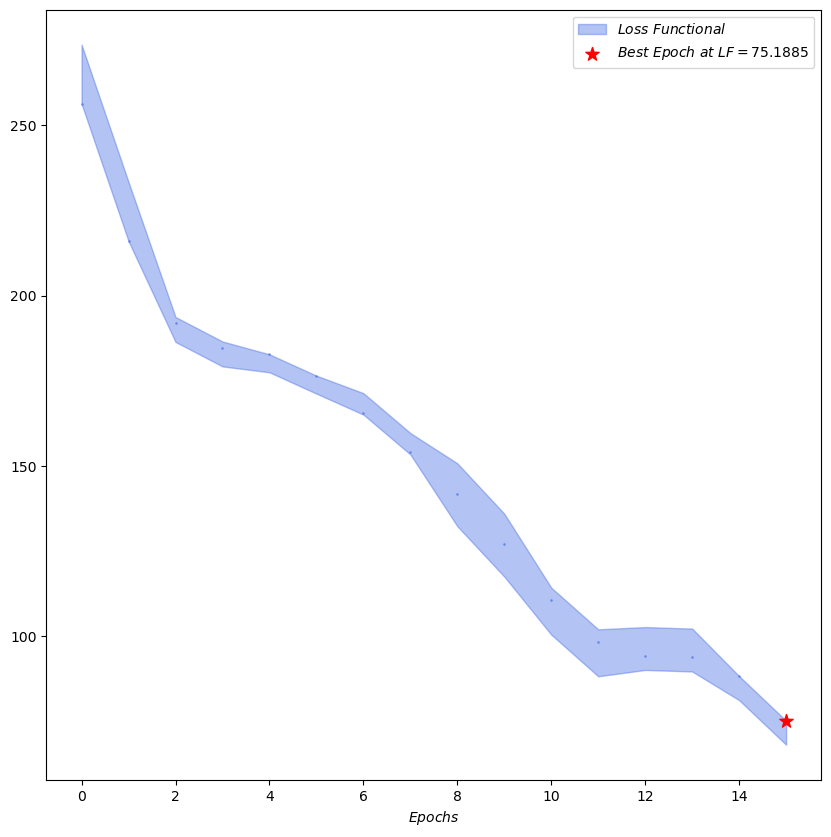

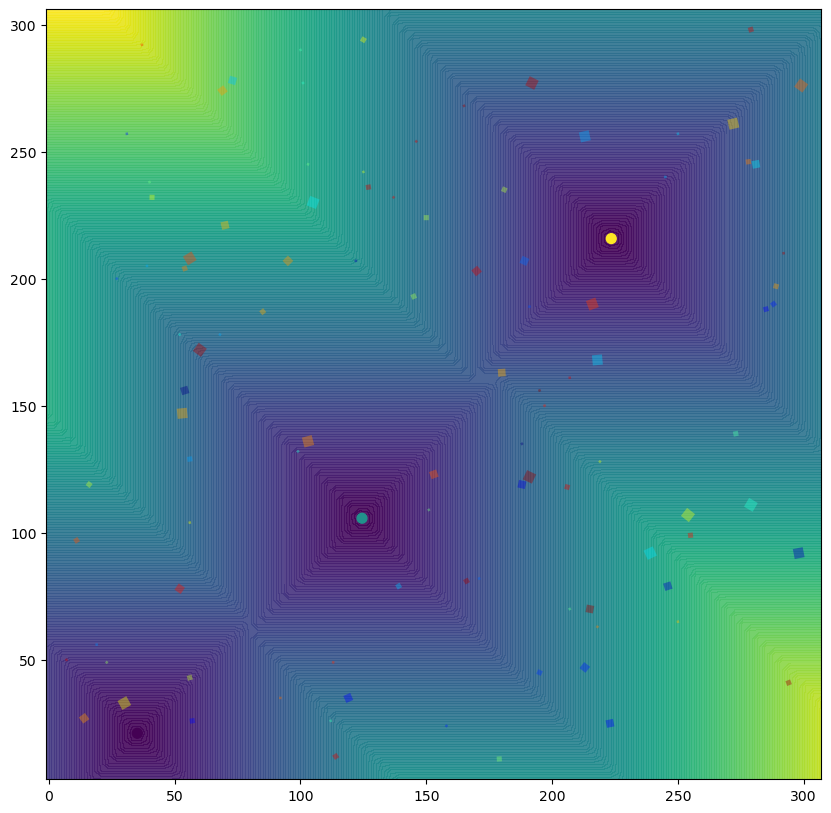

getUncertaintyArea
Ouputs are [[ 35.144657  21.100582]
 [124.447845 105.71562 ]
 [223.50507  215.75581 ]]
scale is 308
Processing...
flag is 248
m is 153
i is 400


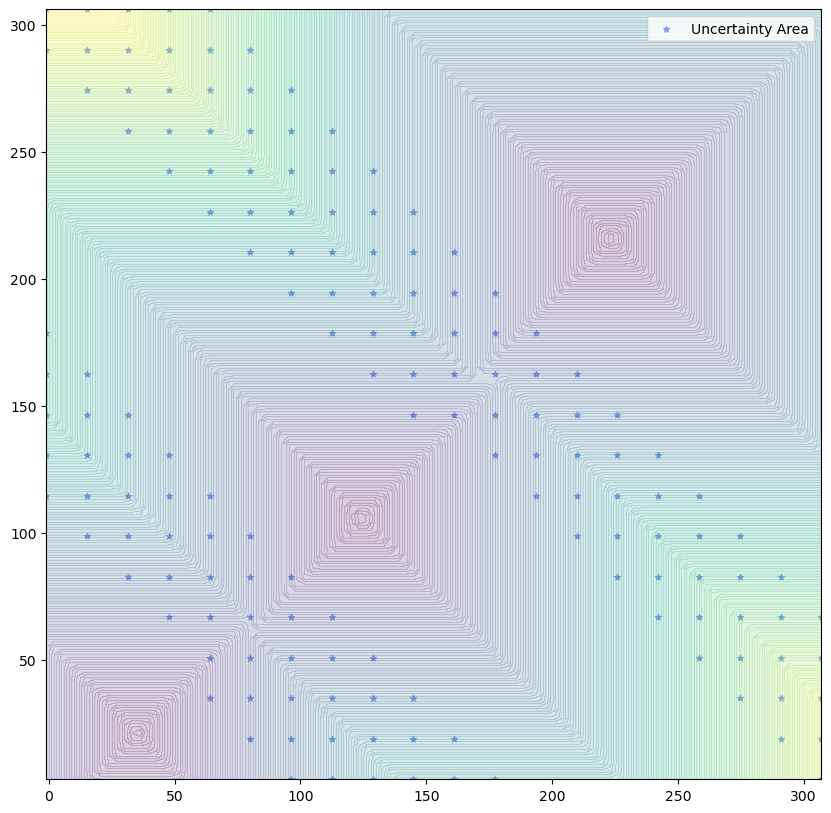

Labeled 0/153 points.
Labeled all 153/153 points.


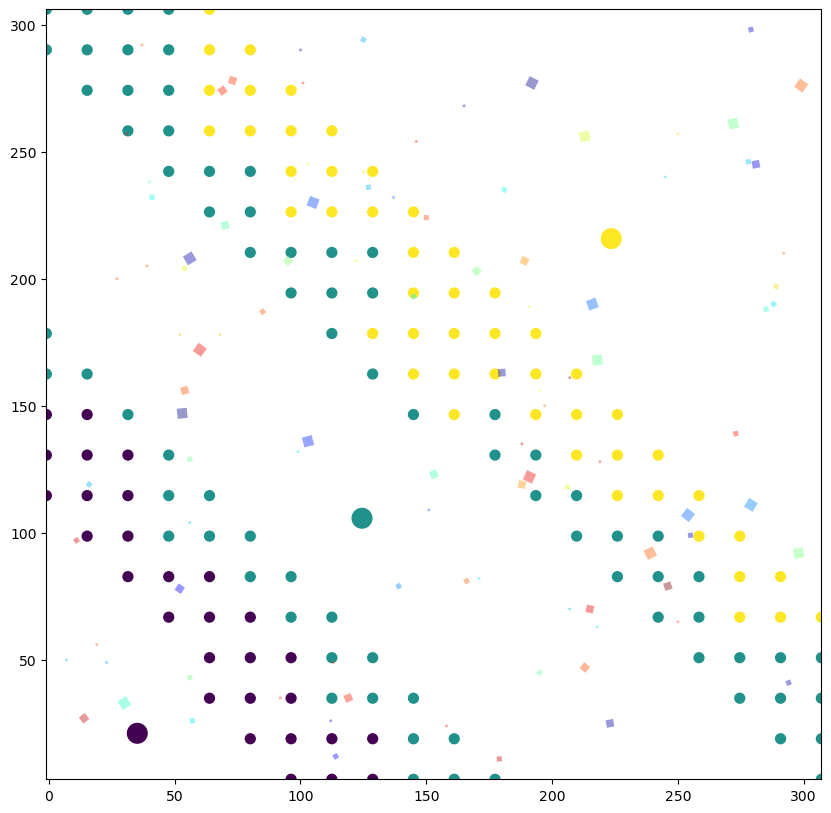

Creating student for node 0 with 3 centroids.
Device is: cuda:0
Training Student Model
Acc:  0.1895424836601307
Epoch:  0 Cost:  337.603515625
Acc:  0.37254901960784315
Epoch:  10 Cost:  102.01071166992188
Acc:  0.5098039215686274
Epoch:  20 Cost:  83.02835845947266
Acc:  0.5228758169934641
Epoch:  30 Cost:  78.21996307373047
Acc:  0.5490196078431373
Epoch:  40 Cost:  74.65516662597656
Acc:  0.6078431372549019
Epoch:  50 Cost:  71.99723815917969
Acc:  0.6209150326797386
Epoch:  60 Cost:  69.85731506347656
Acc:  0.5947712418300654
Epoch:  70 Cost:  68.39620208740234
Acc:  0.6078431372549019
Epoch:  80 Cost:  65.38178253173828
Acc:  0.6013071895424836
Epoch:  90 Cost:  64.20311737060547
Saved student config to models/squares/100/class0_student_config.pt
Saved teacher training results to models/squares/100/class0_student_training_results.npy


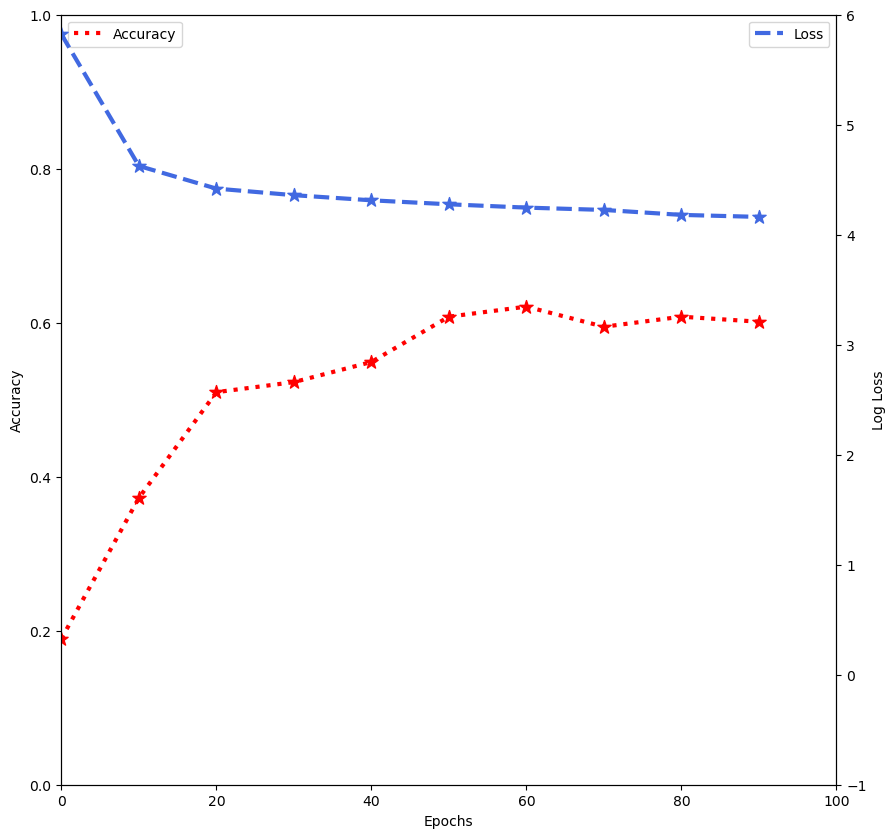

In [3]:
import torch
from src.k_tree import Ktree
from src.utils.data import loadData

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
data, _ = loadData(100)
#data = squares


#data = rects
learning_rate = 5e-3 # 1e-2, 5e-3
k = 3
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 16, # 300
    "times": 1,
    "alpha": 0.01, #  projection loss 0.1
    "beta": 0.1, # latent loss 0.1
    "gamma": 0.4, # repulsive loss 0.01
    "delta": 0.5, # fuzzy scale 0.01
    "f_clk": 10, # 20
    "scale": 1, # fuzzy scale 
    "scale_flag": False,
    "number_of_centroids": k,
    "latent_size": 100,
    "encoder_activation": False,
    "encoder_depth": 3,
    "predictor_width": 5*100,
    "predictor_depth": 3,
}
n = 20
un_args = {
    "N": n,
    "M": n**2-1, # 10000 - 1
    "epsilon": 0.14 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3,
    "epochs": 100, # 30000, 3000
    "width": 200,
    "depth": 5,
}

stop_criterion = 0.1*len(data) if len(data) > 200 else  0.2*len(data) 
#thresshold = 90
thresshold = stop_criterion
thresshold = 93
from src.metrics import Linf_simple
metric = Linf_simple
ktree = Ktree(thresshold, data, metric,teacher_args, un_args, student_args,device=device)
ktree.create_tree(save_path_prefix="models/squares/100/class", plot=True)
#path ='./models/squares/100/class0_student_config.pt'
#ktree.root.create_student_from_config(path)

In [ ]:
# show limits
lim_X = [data[:, 0].min(), data[:, 0].max()]
lim_Y = [data[:, 1].min(), data[:, 1].max()]
print(lim_X,lim_Y)
# get area
s = (lim_X[1] - lim_X[0]) *(lim_Y[1] - lim_Y[0]) 
# show area
print(s)
ball = 0.93 * np.sqrt(10000000*2)
ball *= 100 * np.sqrt(10)
print(4*ball**2/s)

torch.Size([100, 2])
Querying point tensor([ 7., 11.], device='cuda:0')...
cuda:0


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_2500\3782418922.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_point = torch.tensor(query_point)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

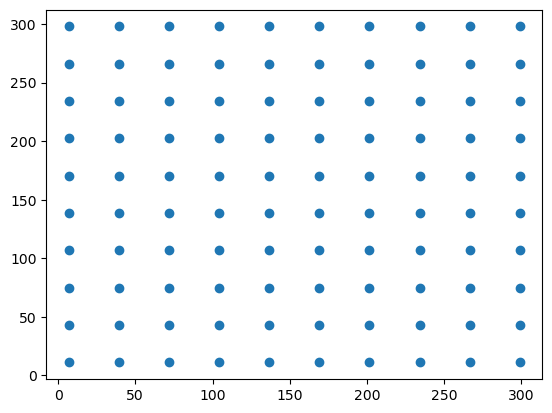

In [4]:
import numpy as np
import matplotlib.pyplot as plt
choice = 0# 0 for regular, 1 for maxsum 
acc = 0
mean_acc = 0
times=0
print_flag = True
random = False
out_of_dist =  False
out_of_manifold = True
#ball =  80
x_lim = min(data[:,0]), max(data[:,0])
y_lim = min(data[:,1]), max(data[:,1])
best_acc = 0
worst_acc = 100
#np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
while times < 1:
    # now lets create randomly N points in the space 0-300, 0-300
    # [[-6, 257], [-6, 179]]
    n = 10**2
    if random:
        # do seed for reproducability 
        random_p = torch.zeros(n, 2)
        for i in range(n):
            random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
        infer_points = random_p.to(device)
    else:
        nop =  n
        random_p = torch.zeros(nop, 2)
        #x_lim = [0,300]
        #y_lim = [0,300]
        num = int(np.sqrt(nop))
        for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
            for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
                random_p[i*num+j] = torch.Tensor([x, y])

        infer_points = random_p
        print(infer_points.shape)
        plt.scatter(infer_points[:,0], infer_points[:,1])
        infer_points = random_p.to(device)

    if out_of_dist and out_of_manifold:
        # plot points outside 0,300
        x_lim = [x_lim[0]-ball, x_lim[1]+ball]
        y_lim = [y_lim[0]-ball, y_lim[1]+ball]
        num = int(np.sqrt(nop))
        for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
            for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
                random_p[i*num+j] = torch.Tensor([x, y])
        infer_points = random_p.to(device)
        print(infer_points.shape)
        plt.scatter(infer_points[:,0], infer_points[:,1])
    num_of_correct_predictions = 0
    qp = infer_points.to(device)
    z_wrong = np.zeros(len(qp))
    z_label_wrong = np.zeros(len(qp))
    #qp = torch.tensor(qp)
    for i in range(len(qp)-1):
        if choice == 0:
            query_point = qp[i]
            query_point = torch.tensor(query_point)
            pred = ktree.query(query_point)
            brute_force = ktree.root.query(query_point)
            #print(pred)
            #print(brute_force)
        if choice ==1:
            query_point = qp[i:i+1]
            query_point = torch.tensor(query_point)
            pred = ktree.query_maxsum(query_point)[0]
            brute_force = ktree.root.query(query_point[0])
            print(pred)
            print(brute_force)
        if choice ==2:
            query_point = qp[i:i+1]
            query_point = torch.tensor(query_point)
            pred = ktree.query_maxcumsum(query_point)[0]
            brute_force = ktree.root.query(query_point[0])
            print(pred)
            print(brute_force)
        # print(pred)
        # print(brute_force)
        if(np.array_equal(pred, brute_force)):
            num_of_correct_predictions += 1
        else:
            z_wrong[i] = max(abs(pred[:2]-brute_force[:2]))
            if z_wrong[i] > 0.1:
                z_label_wrong[i] = 1

            if print_flag:
                print("="*20)
                print(f"Query point {i}")
                print(f"Wrong prediction for {query_point}")
                print(f"Predicted {pred}")
                print(f"Brute force {brute_force}")
                print("="*20)
                # reshape z_wong to be a 2d array
    axis = int(np.sqrt(len(qp)))
    # make contour of the z_wrong
    x = np.linspace(x_lim[0],x_lim[1], axis)                                        
    y = np.linspace(y_lim[0],y_lim[1], axis)
    X, Y = np.meshgrid(x, y)
    Z = z_wrong.reshape(X.shape)
    if out_of_dist and out_of_manifold:
        # make 0 in Z all values between 0,300, 0,300
        # first find index in X 
        #x_index = np.where((X>=x_lim[0]+ball) & (X<= x_lim[1]-ball))
        x_index = np.where((X>=x_lim[0]+ball) & (X<= x_lim[1]-ball))
        # now make Z 0 in these indexes
        Z[x_index] = 0
        
    # make 3d plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.contourf(X, Y, Z, 200, cmap='viridis')
    # rotate
    ax.view_init(45, 30)
    acc = num_of_correct_predictions / len(infer_points) * 100
    if acc > best_acc:
        best_acc = acc
    if acc < worst_acc:
        worst_acc = acc

    mean_acc += acc
    times += 1

    print(f"The percentage of correct predictions is {acc:.2f}%")

print(f"The best percentage of correct predictions is {best_acc:.2f}%")
print(f"The mean percentage of correct predictions is {mean_acc/times:.2f}%")
print(f"The worst percentage of correct predictions is {worst_acc:.2f}%")

In [ ]:
#ktree.root.student
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
infer_point = infer_points[0].to(device)
# get device of student
d = ktree.root.student(infer_point)


In [ ]:
# get indexes for all leaves
leaves = ktree.get_leaves()
indx = []
for leaf in leaves:
    indx.append(leaf.index)
print(indx)
# sort indexes in terms of length
indx.sort(key=len)
print(indx)


In [ ]:
# infer points= random from infer_points
# plot a random point in x_lim, y_lim
n = np.random.randint(0, len(infer_points))
infer_point = infer_points[n].to(device)
#bf = ktree.root.query(infer_point)
pred = ktree.query(infer_point)
print(pred)
print(bf)


In [ ]:
# root.student
st = ktree.root.student
device = 'cpu'


In [ ]:
%%timeit
pred = st(infer_point)

In [ ]:
%%timeit
pred = ktree.query(infer_point)

In [ ]:
%%timeit
bf = ktree.root.query(infer_point)

In [ ]:
n = 100
random_p = torch.zeros(n, 2)
for i in range(n):
    random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
infer_points = random_p
print(infer_points.shape)
r = ktree.query_maxsum(query_point)
r[0]

In [ ]:
# flags
wanna_plot_square = True
# do a 2d contour
fig, ax = plt.subplots()
axis = int(np.sqrt(len(qp)))

for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], axis)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], axis)):
        random_p[i*axis+j] = torch.Tensor([x, y])
infer_points = random_p.to(device)
y = np.linspace(y_lim[0],y_lim[1], axis)
x = np.linspace(x_lim[0],x_lim[1], axis)
X = np.meshgrid(x, y)[0]
Y = np.meshgrid(x, y)[1]
label = ktree.root.student(qp).max(1)[-1].detach().cpu().numpy()
Z_ = label.reshape(X.shape)
#plt.contourf(X, Y, Z_, 100, cmap='viridis')
#ax.contourf(X, Y, Z, 100, cmap='viridis')
ax.contourf(X, Y, Z_, 100, cmap='rainbow',alpha =0.5)
# add colorbar
fig.colorbar(ax.contourf(X, Y, Z, 100, cmap='viridis',alpha = 0.2))
# make color bar of Z_
# plot a scatter of wrong predictions
# make new label
#ax.scatter(qp[:,0], qp[:,1], c=z_label_wrong, cmap='bwr')
#plt.colorbar()
# do a plot of the area [0,300]
# plot a square centered at 0,0 with length 300
if wanna_plot_square:
    domain_limits = min(data[:,0]), max(data[:,0]), min(data[:,1]), max(data[:,1])
    plt.plot([domain_limits[0], domain_limits[1]], [domain_limits[2], domain_limits[2]], c='r')
    plt.plot([domain_limits[0], domain_limits[1]], [domain_limits[3], domain_limits[3]], c='r')
    plt.plot([domain_limits[0], domain_limits[0]], [domain_limits[2], domain_limits[3]], c='r')
    plt.plot([domain_limits[1], domain_limits[1]], [domain_limits[2], domain_limits[3]], c='r')

#for square in squares:
#    ax.add_patch(Rectangle((square[0], square[1]), square[2], square[2], angle=np.deg2rad(square[3]), fill=False))
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.show()


#plt.show()

In [ ]:
len(ktree.get_leaves())

## Results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import torch
# do latex in matplotlib


r = np.array([
    [100, 96.1,71.25,66.75,66,65.75,65.5,65.26],
    [100,	94.5,	82.75,	82.5,	82.25,	82,	81.75,	81.75],
    [0.9843*100,	96.75,	66.67,	65.75,	64.00,	63.00,	63.00,	63.00],
    [100,	97.00,	73.25,	71.00,	72.00,	73.00,	73.00,	73.00],
    [0.9819*100,96.25,61.00,	62.00,	62.75,	61.75,	62.00,	62.00]
])
# plot
fig, ax = plt.subplots(figsize=(20,10))
marker = ['*', 'o', 'v', 's', 'p']
labels = ['Half Moon', 'Two Moons', 'S shape', '4 Blobs', 'Swiss Roll']
for i in range(r.shape[0]):
    ax.plot(r[i, :], label=labels[i], marker=marker[i],markersize=10)
# name x axis values from 0,1,2 to strings
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(['$D$', 
                    '$OOD\ IM$', '$OOM(*0.1k)$', '$OOM(*1k)$', '$OOM(*10k)$', '$OOM(*100k)$', '$OOM(*1m)$', '$OOM(*10m)$'], fontsize=15)
# do latex inside of legend

# make text rotated
ax.set_ylabel('$Accuracy$', fontsize=15, rotation=0, labelpad=20)
# erotate labels
plt.xticks(rotation=45)
ax.legend()
# make legend bigger
ax.legend(prop={'size': 15})
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.rand(100)
# plot
fig, ax = plt.subplots()
ax.plot(x, marker='o')
# add legend
ax.legend(['$test$'])
# add legend